Epoch 1/2
13938/13938 [==============================] - 307s - loss: 0.0353 - val_loss: 0.0406
Epoch 2/2
13938/13938 [==============================] - 313s - loss: 0.0313 - val_loss: 0.0342
dict_keys(['val_loss', 'loss'])


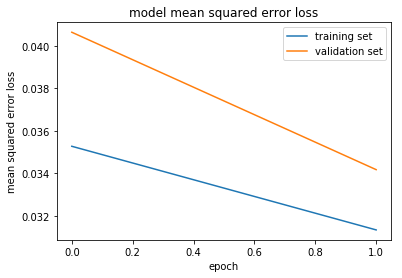

In [2]:
import os
import csv

samples = []
with open('C:/Users/karee/Desktop/Simulator Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
              
            images = []
            angles = []
            correction_factor = [0., 0.1, -0.1]
            for batch_sample in batch_samples:
                for i in range(3):
                    source_path = batch_sample[i]
                    source_path_conv = source_path.replace('\\', '/')
                    image = cv2.imread(source_path_conv)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    angle = float(batch_sample[3])
                    images.append(image)
                    angles.append(angle + correction_factor[i])
            augmented_images, augmented_angles = [], []
            for image, angle in zip(images, angles):
                augmented_images.append(image)
                augmented_angles.append(angle)
                augmented_images.append(cv2.flip(image, 1))
                augmented_angles.append(angle*-1.0)
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Activation, Dropout, Cropping2D
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Dropout(0.5))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))

import matplotlib.pyplot as plt

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=6*len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=2, verbose=1)

print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')